<a href="https://colab.research.google.com/github/cyrus-bcc/FAP_FinalProj/blob/main/ML_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import cv2
from sklearn.model_selection import train_test_split

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define constants
IMG_SIZE = 64
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 20

#Dataset (Load and divison of Tran, Test, Validation)

In [ ]:
# Class names for EuroSat dataset
CLASS_NAMES = [
    'Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway',
    'Industrial', 'Pasture', 'Permanent Crop', 'Residential',
    'River', 'Sea & Lake'
]

In [ ]:
def load_eurosat_dataset():
    """
    Load the EuroSat dataset using TensorFlow Datasets
    """
    import tensorflow_datasets as tfds

    print("Loading EuroSat dataset...")
    (ds_train, ds_val, ds_test), ds_info = tfds.load(
        'eurosat/rgb',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        with_info=True,
        as_supervised=True,
    )

    print(f"Dataset loaded: {len(ds_train)} training, {len(ds_val)} validation, {len(ds_test)} test samples")

    # Get the number of classes
    num_classes = ds_info.features['label'].num_classes
    print(f"Number of classes: {num_classes}")

    # Get class names if available
    try:
        class_names = ds_info.features['label'].names
        print(f"Class names: {class_names}")
    except:
        print("Class names not available in dataset info")
        class_names = CLASS_NAMES

    return ds_train, ds_val, ds_test, class_names


In [ ]:
def preprocess_dataset(ds_train, ds_val, ds_test):
    """
    Preprocess the datasets: resize, normalize, and batch
    """
    def preprocess(image, label):
        """Resize images and normalize pixel values"""
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
        return image, label

    # Apply preprocessing
    ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # Cache, shuffle, batch, and prefetch the training dataset
    ds_train = ds_train.cache().shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    ds_val = ds_val.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    ds_test = ds_test.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return ds_train, ds_val, ds_test

#ResNet50: Feature Extraction Model (Don't Change since we're using ResNet50)

In [ ]:
def create_feature_extractor_model():
    """
    Create a model that uses ResNet50 as a feature extractor (all layers frozen)
    """
    # Load pre-trained ResNet50 without the top classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

#Base Model: Fine Tuned Model

In [ ]:
def create_fine_tuned_model(feature_extractor_model):
    """
    Create a fine-tuned model by unfreezing some of the layers
    """
    # Clone the feature extractor model to start fresh
    model = tf.keras.models.clone_model(feature_extractor_model)
    model.set_weights(feature_extractor_model.get_weights())

    # Get the base model (ResNet50)
    base_model = model.layers[0]

    # Unfreeze the last 30 layers of the ResNet50 model
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    # Recompile the model with a lower learning rate for fine-tuning
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),  # Use a lower learning rate for fine-tuning
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

Model: Pooling and Size

In [ ]:
def create_fine_tuned_model_maxpooling(feature_extractor_model):
    """
    Create a fine-tuned model by unfreezing some of the layers and adding MaxPooling
    """
    base_model = feature_extractor_model.layers[0]

    # Unfreeze the last 30 layers of the base model
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    # Build a new model with MaxPooling2D added
    inputs = tf.keras.Input(shape=(64, 64, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)  # adjust num_classes if needed
    model = tf.keras.Model(inputs, x)

    # Compile the model for fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


#Trains Model and Returns History for Evaluation

In [ ]:
def train_model(model, ds_train, ds_val, model_name="model"):
    """
    Train the model and return training history
    """
    # Create callbacks
    checkpoint_cb = ModelCheckpoint(
        f"{model_name}_best.h5",
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )

    early_stopping_cb = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )

    reduce_lr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )

    # Train the model
    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=EPOCHS,
        callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
    )

    return history

#Call Model for Evaluation

In [ ]:
def evaluate_model(model, ds_test, class_names, title="Model Evaluation"):
    """
    Evaluate the model performance and visualize confusion matrix
    """
    # Evaluate the model
    test_loss, test_acc = model.evaluate(ds_test)
    print(f"\n{title}:")
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Get predictions
    all_labels = []
    all_preds = []

    for images, labels in ds_test:
        preds = model.predict(images)
        pred_classes = np.argmax(preds, axis=1)

        all_labels.extend(labels.numpy())
        all_preds.extend(pred_classes)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {title}')
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{title.replace(' ', '_')}.png")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return all_labels, all_preds

#History of Model

In [ ]:
def visualize_training_history(history_feature_extractor, history_fine_tuned):
    """
    Visualize the training history for both models
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history_feature_extractor.history['accuracy'], label='Feature Extractor - Training')
    ax1.plot(history_feature_extractor.history['val_accuracy'], label='Feature Extractor - Validation')
    ax1.plot(history_fine_tuned.history['accuracy'], label='Fine-Tuned - Training')
    ax1.plot(history_fine_tuned.history['val_accuracy'], label='Fine-Tuned - Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history_feature_extractor.history['loss'], label='Feature Extractor - Training')
    ax2.plot(history_feature_extractor.history['val_loss'], label='Feature Extractor - Validation')
    ax2.plot(history_fine_tuned.history['loss'], label='Fine-Tuned - Training')
    ax2.plot(history_fine_tuned.history['val_loss'], label='Fine-Tuned - Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig("training_history_comparison.png")
    plt.show()

#Sample Predictions of Model

In [ ]:
def visualize_sample_predictions(ds_test, model, class_names, num_samples=10):
    """
    Visualize sample predictions from the test set
    """
    # Get a batch of test images
    images, labels = next(iter(ds_test))

    # Get predictions
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(min(num_samples, len(images))):
        img = images[i].numpy()
        true_label = class_names[labels[i]]
        pred_label = class_names[pred_classes[i]]

        # Display image
        axes[i].imshow(img)

        # Set title green if correct, red if incorrect
        title_color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("sample_predictions.png")
    plt.show()

In [ ]:
def generate_class_activation_maps(model, ds_test, class_names, num_samples=5):
    """
    Generate and visualize Class Activation Maps (CAM) to see what the model focuses on

    Args:
        model: Trained model
        ds_test: Test dataset
        class_names: List of class names
        num_samples: Number of samples to visualize
    """
    try:
        # First, ensure the model has been built by passing a sample batch
        for images, _ in ds_test.take(1):
            # Just do a forward pass to ensure the model is built
            _ = model.predict(images)
            break

        # Find the ResNet50 base model
        base_model = None
        for layer in model.layers:
            if isinstance(layer, tf.keras.Model):
                base_model = layer
                break

        if base_model is None:
            print("Could not find the ResNet50 base model")
            return

        # Find the last convolutional layer
        last_conv_layer_name = None
        for layer in reversed(base_model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer_name = layer.name
                break

        if last_conv_layer_name is None:
            print("Could not find the last convolutional layer")
            return

        # Create a model to get the feature maps from the last conv layer
        feature_map_model = tf.keras.Model(
            inputs=base_model.input,
            outputs=base_model.get_layer(last_conv_layer_name).output
        )

        # Get a batch of test images
        images, labels = next(iter(ds_test))

        # Limit to num_samples
        images = images[:num_samples]
        labels = labels[:num_samples]

        # If needed, resize images for ResNet50
        if IMG_SIZE != 224:
            resized_images = tf.image.resize(images, [224, 224])
        else:
            resized_images = images

        # Get predictions
        preds = model.predict(images)
        pred_classes = np.argmax(preds, axis=1)

        # Get feature maps (use resized images for ResNet50)
        feature_maps = feature_map_model.predict(resized_images)

        # Find the dense layer with output classes (our classification layer)
        dense_layer = None
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Dense) and layer.units == len(class_names):
                dense_layer = layer
                break

        if dense_layer is None:
            print("Could not find the classification dense layer")
            return

        # Get the weights of the output dense layer
        dense_layer_weights = dense_layer.get_weights()[0]

        # Create a figure to display the images and their CAMs
        fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))

        for i in range(num_samples):
            img = images[i].numpy()
            true_label = class_names[labels[i]]
            pred_label = class_names[pred_classes[i]]
            pred_prob = preds[i][pred_classes[i]]

            # Get the weights for the predicted class
            class_weights = dense_layer_weights[:, pred_classes[i]]

            # Compute the class activation map
            feature_map = feature_maps[i]
            # Handle dimension mismatch between weights and feature maps
            num_features = min(len(class_weights), feature_map.shape[-1])

            cam = np.zeros(feature_map.shape[0:2], dtype=np.float32)

            # Use only the first num_features weights and feature maps
            for j in range(num_features):
                cam += class_weights[j] * feature_map[:, :, j]

            # Normalize the CAM
            cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
            cam = np.maximum(cam, 0)
            cam = cam / np.max(cam) if np.max(cam) > 0 else cam

            # Create a heatmap
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

            # Superimpose the heatmap on the original image
            img_array = np.uint8(img * 255)
            superimposed = heatmap * 0.4 + img_array
            superimposed = np.clip(superimposed, 0, 255).astype('uint8')

            # Display the original image
            axes[i, 0].imshow(img)
            title_color = 'green' if true_label == pred_label else 'red'
            axes[i, 0].set_title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})",
                              color=title_color)
            axes[i, 0].axis('off')

            # Display the CAM
            axes[i, 1].imshow(superimposed)
            axes[i, 1].set_title("Class Activation Map")
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.savefig("class_activation_maps.png")
        plt.show()

    except Exception as e:
        print(f"Error generating class activation maps: {e}")
        import traceback
        traceback.print_exc()

#Start Here

No Need to Change (Extraction of Image using ResNet50 and Evaluation of the Extracted Features remains the same)

Loading EuroSat dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.8723JP_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Dataset loaded: 21600 training, 2700 validation, 2700 test samples
Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

===== Training Feature Extractor Model (Base Model Frozen) =====
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
672/675 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2072 - loss: 2.1686

675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.2076 - loss: 2.1677 - val_accuracy: 0.4415 - val_loss: 1.7464 - learning_rate: 0.0010
Epoch 2/20
673/675 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3539 - loss: 1.7436

675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3540 - loss: 1.7434 - val_accuracy: 0.4574 - val_loss: 1.5640 - learning_rate: 0.0010
Epoch 3/20
673/675 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3987 - loss: 1.6216

675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3987 - loss: 1.6216 - val_accuracy: 0.4722 - val_loss: 1.4915 - learning_rate: 0.0010
Epoch 4/20
671/675 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4240 - loss: 1.5636

675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4240 - loss: 1.5636 - val_accuracy: 0.4785 - val_loss: 1.4716 - learning_rate: 0.0010
Epoch 5/20
671/675 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4422 - loss: 1.5313

675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4422 - loss: 1.5312 - val_accuracy: 0.5056 - val_loss: 1.4325 - learning_rate: 0.0010
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4539 - loss: 1.5041

675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4539 - loss: 1.5040 - val_accuracy: 0.5152 - val_loss: 1.3830 - learning_rate: 0.0010
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4478 - loss: 1.4841

675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.4478 - loss: 1.4841 - val_accuracy: 0.5237 - val_loss: 1.3643 - learning_rate: 0.0010
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4658 - loss: 1.4620 - val_accuracy: 0.5141 - val_loss: 1.3506 - learning_rate: 0.0010
Epoch 9/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4674 - loss: 1.4365 - val_accuracy: 0.5041 - val_loss: 1.3281 - learning_rate: 0.0010
Epoch 10/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4738 - loss: 1.4361 - val_accuracy: 0.5207 - val_loss: 1.3314 - learning_rate: 0.0010
Epoch 11/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4749 - loss: 1.4326

675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4749 - loss: 1.4326 - val_accuracy: 0.5259 - val_loss: 1.3067 - learning_rate: 0.0010
Epoch 12/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4762 - loss: 1.4231 - val_accuracy: 0.5248 - val_loss: 1.3161 - learning_rate: 0.0010
Epoch 13/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4843 - loss: 1.4131 - val_accuracy: 0.5096 - val_loss: 1.3390 - learning_rate: 0.0010
Epoch 14/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4821 - loss: 1.4172 - val_accuracy: 0.5111 - val_loss: 1.3246 - learning_rate: 0.0010
Epoch 15/20
674/675 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5007 - loss: 1.3680

675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5007 - loss: 1.3680 - val_accuracy: 0.5559 - val_loss: 1.2731 - learning_rate: 5.0000e-04
Epoch 16/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5182 - loss: 1.3499 - val_accuracy: 0.5400 - val_loss: 1.2638 - learning_rate: 5.0000e-04
Epoch 17/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5092 - loss: 1.3492 - val_accuracy: 0.5537 - val_loss: 1.2570 - learning_rate: 5.0000e-04
Epoch 18/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5127 - loss: 1.3585 - val_accuracy: 0.5393 - val_loss: 1.2560 - learning_rate: 5.0000e-04
Epoch 19/20
674/675 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5101 - loss: 1.3523

675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5101 - loss: 1.3523 - val_accuracy: 0.5659 - val_loss: 1.2632 - learning_rate: 5.0000e-04
Epoch 20/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5159 - loss: 1.3339 - val_accuracy: 0.5481 - val_loss: 1.2312 - learning_rate: 5.0000e-04
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5701 - loss: 1.2740

Feature Extractor Model:
Test accuracy: 0.5693
Test loss: 1.2561
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

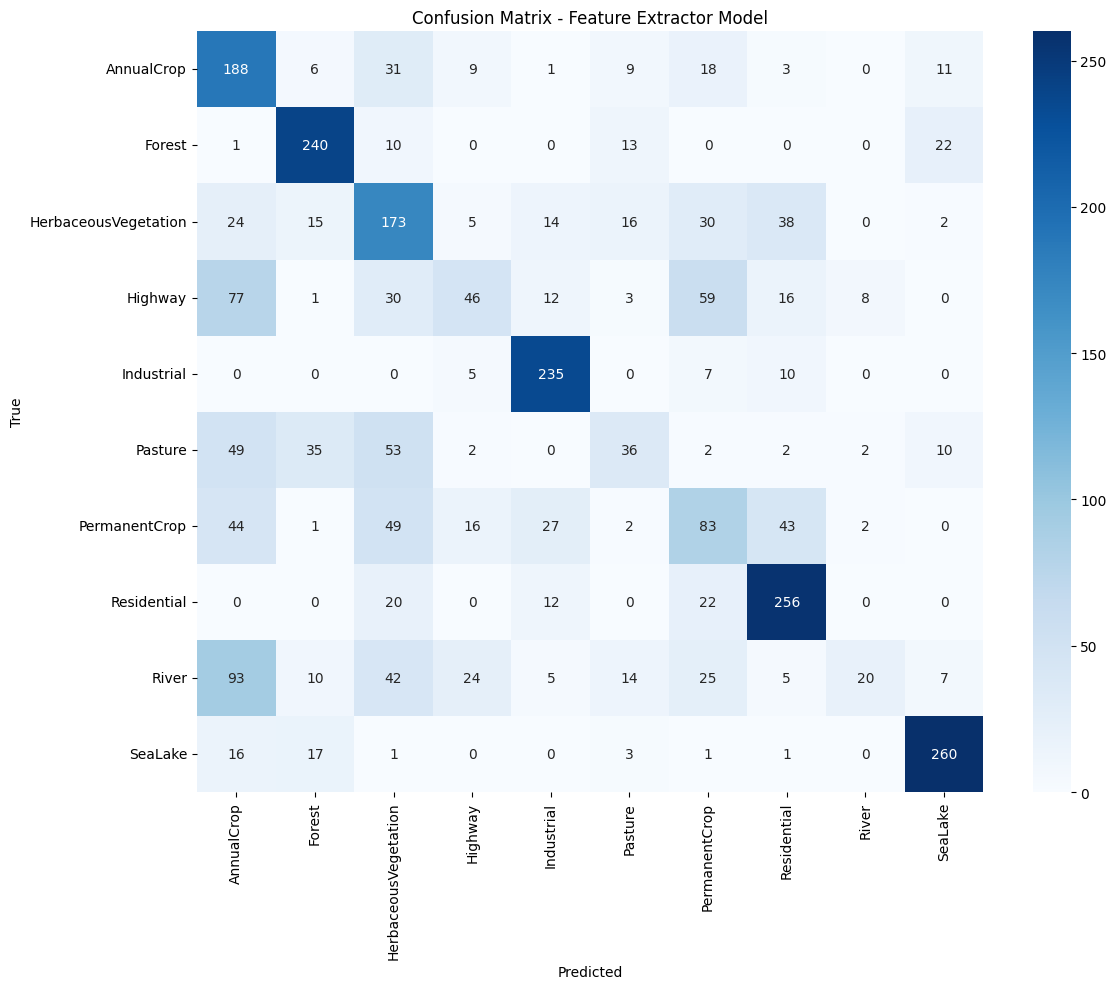


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.38      0.68      0.49       276
              Forest       0.74      0.84      0.79       286
HerbaceousVegetation       0.42      0.55      0.48       317
             Highway       0.43      0.18      0.26       252
          Industrial       0.77      0.91      0.83       257
             Pasture       0.38      0.19      0.25       191
       PermanentCrop       0.34      0.31      0.32       267
         Residential       0.68      0.83      0.75       310
               River       0.62      0.08      0.14       245
             SeaLake       0.83      0.87      0.85       299

            accuracy                           0.57      2700
           macro avg       0.56      0.54      0.52      2700
        weighted avg       0.57      0.57      0.54      2700



In [ ]:
# Create output directory for results
os.makedirs("results", exist_ok=True)

# Load dataset
ds_train, ds_val, ds_test, class_names = load_eurosat_dataset()

# Preprocess dataset
ds_train, ds_val, ds_test = preprocess_dataset(ds_train, ds_val, ds_test)

# Step 1: Create and train the feature extractor model (base model frozen)
print("\n===== Training Feature Extractor Model (Base Model Frozen) =====")
feature_extractor_model = create_feature_extractor_model()
feature_extractor_model.summary()
history_feature_extractor = train_model(feature_extractor_model, ds_train, ds_val,
                                           model_name="feature_extractor")

# Step 2: Evaluate the feature extractor model
labels_fe, preds_fe = evaluate_model(feature_extractor_model, ds_test, class_names,
                                       title="Feature Extractor Model")


#Change Model

Base Model


===== Training Fine-Tuned Model (Some Layers Unfrozen) =====


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 14,977,290 (57.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

Epoch 1/20
673/675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3520 - loss: 6.2986

675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.3522 - loss: 6.2844 - val_accuracy: 0.3822 - val_loss: 1.8147 - learning_rate: 1.0000e-05
Epoch 2/20
673/675 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4698 - loss: 1.4771

675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.4699 - loss: 1.4769 - val_accuracy: 0.5500 - val_loss: 1.2719 - learning_rate: 1.0000e-05
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5239 - loss: 1.3282 - val_accuracy: 0.4574 - val_loss: 1.6192 - learning_rate: 1.0000e-05
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5575 - loss: 1.2310 - val_accuracy: 0.5041 - val_loss: 1.5166 - learning_rate: 1.0000e-05
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5988 - loss: 1.1379 - val_accuracy: 0.4448 - val_loss: 1.6466 - learning_rate: 1.0000e-05
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6232 - loss: 1.0307

675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.6232 - loss: 1.0307 - val_accuracy: 0.6585 - val_loss: 0.9674 - learning_rate: 5.0000e-06
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6553 - loss: 0.9734 - val_accuracy: 0.6067 - val_loss: 1.0974 - learning_rate: 5.0000e-06
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6613 - loss: 0.9440 - val_accuracy: 0.4574 - val_loss: 2.3933 - learning_rate: 5.0000e-06
Epoch 9/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6766 - loss: 0.9042 - val_accuracy: 0.3793 - val_loss: 4.6037 - learning_rate: 5.0000e-06
Epoch 10/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6898 - loss: 0.8633 - val_accuracy: 0.6500 - val_loss: 1.0190 - learning_rate: 2.5000e-06
Epoch 11/20
673/675 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7008 - loss: 0.8351

675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.7008 - loss: 0.8350 - val_accuracy: 0.6604 - val_loss: 1.0844 - learning_rate: 2.5000e-06
Epoch 12/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.7182 - loss: 0.7913 - val_accuracy: 0.5970 - val_loss: 1.3102 - learning_rate: 2.5000e-06
Epoch 13/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7243 - loss: 0.7795 - val_accuracy: 0.6341 - val_loss: 1.0655 - learning_rate: 1.2500e-06
Epoch 14/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.7371 - loss: 0.7384 - val_accuracy: 0.6370 - val_loss: 1.0199 - learning_rate: 1.2500e-06
Epoch 15/20
673/675 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7375 - loss: 0.7328

675/675 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.7375 - loss: 0.7328 - val_accuracy: 0.7433 - val_loss: 0.7596 - learning_rate: 1.2500e-06
Epoch 16/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.7334 - loss: 0.7354 - val_accuracy: 0.7219 - val_loss: 0.8243 - learning_rate: 1.2500e-06
Epoch 17/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.7462 - loss: 0.7092 - val_accuracy: 0.6870 - val_loss: 0.9474 - learning_rate: 1.2500e-06
Epoch 18/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.7497 - loss: 0.7113 - val_accuracy: 0.6870 - val_loss: 0.9466 - learning_rate: 1.2500e-06
Epoch 19/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.7560 - loss: 0.6794 - val_accuracy: 0.7219 - val_loss: 0.8450 - learning_rate: 1.0000e-06
Epoch 20/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7618 - loss: 0.6672 - val_accuracy: 0.7274 - val_loss: 0.7766 - learning_rate: 1.0000e-06
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7424

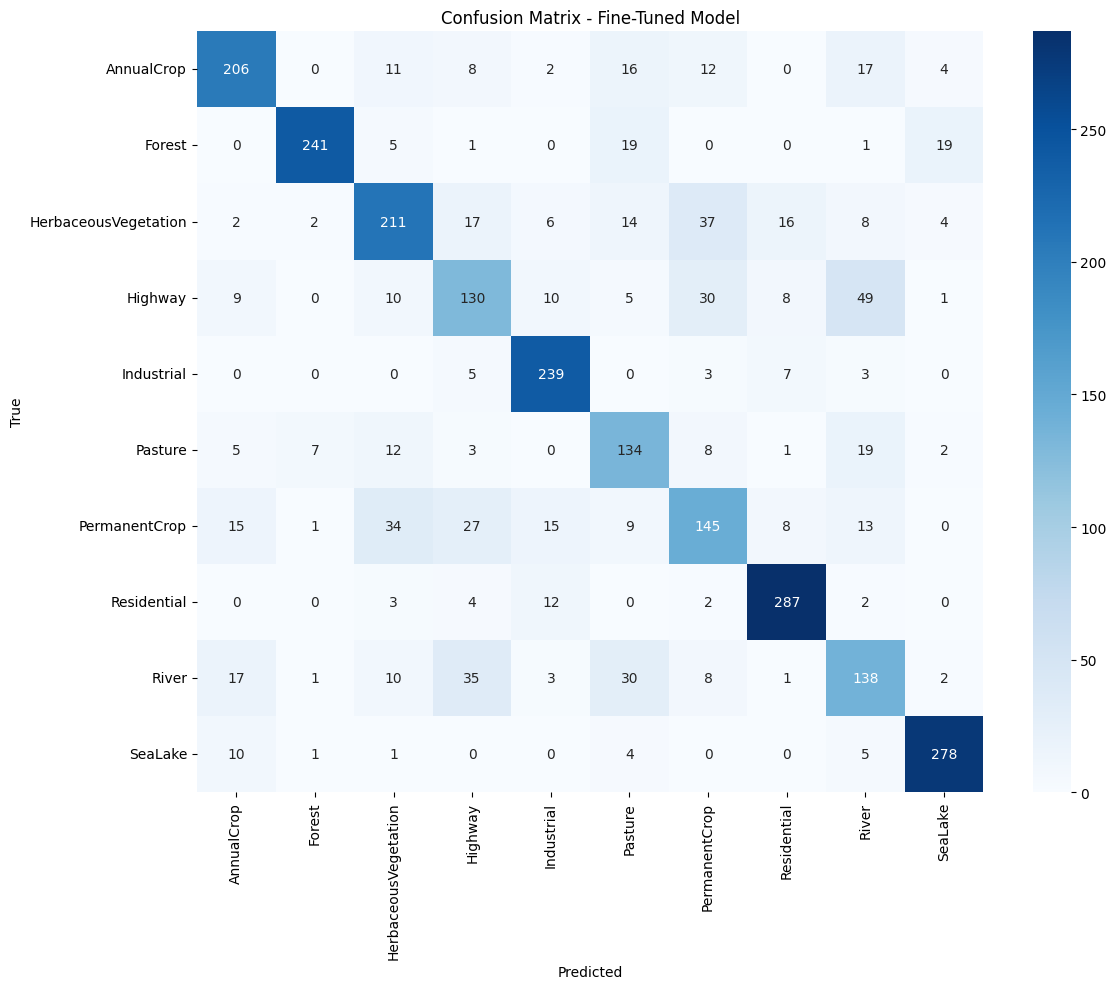


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.78      0.75      0.76       276
              Forest       0.95      0.84      0.89       286
HerbaceousVegetation       0.71      0.67      0.69       317
             Highway       0.57      0.52      0.54       252
          Industrial       0.83      0.93      0.88       257
             Pasture       0.58      0.70      0.64       191
       PermanentCrop       0.59      0.54      0.57       267
         Residential       0.88      0.93      0.90       310
               River       0.54      0.56      0.55       245
             SeaLake       0.90      0.93      0.91       299

            accuracy                           0.74      2700
           macro avg       0.73      0.74      0.73      2700
        weighted avg       0.74      0.74      0.74      2700



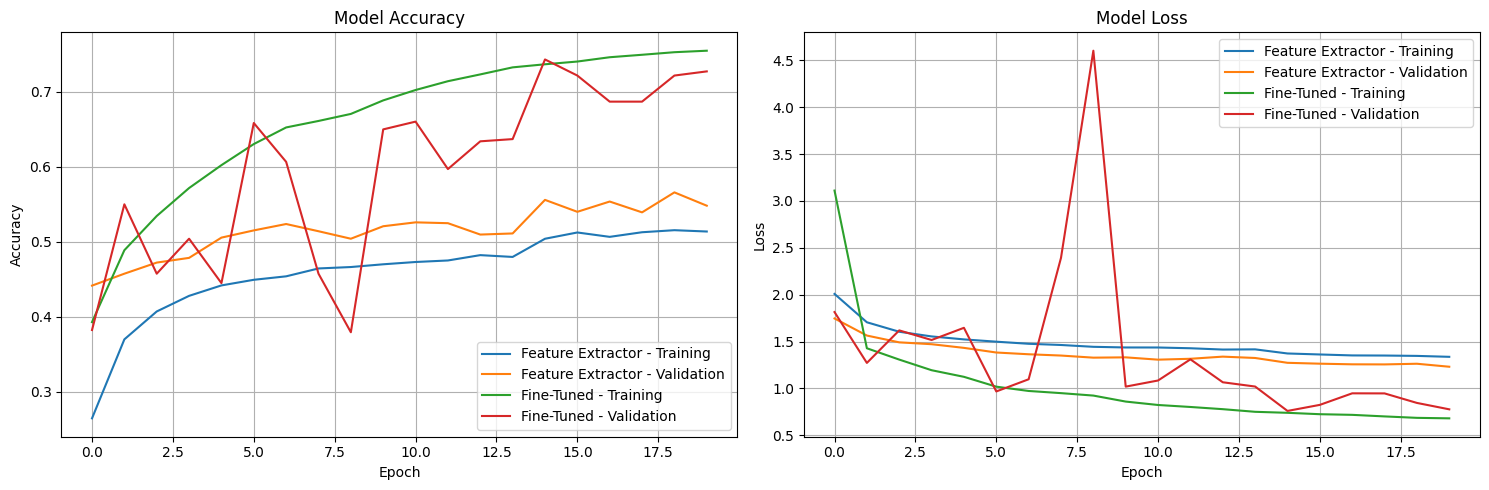

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


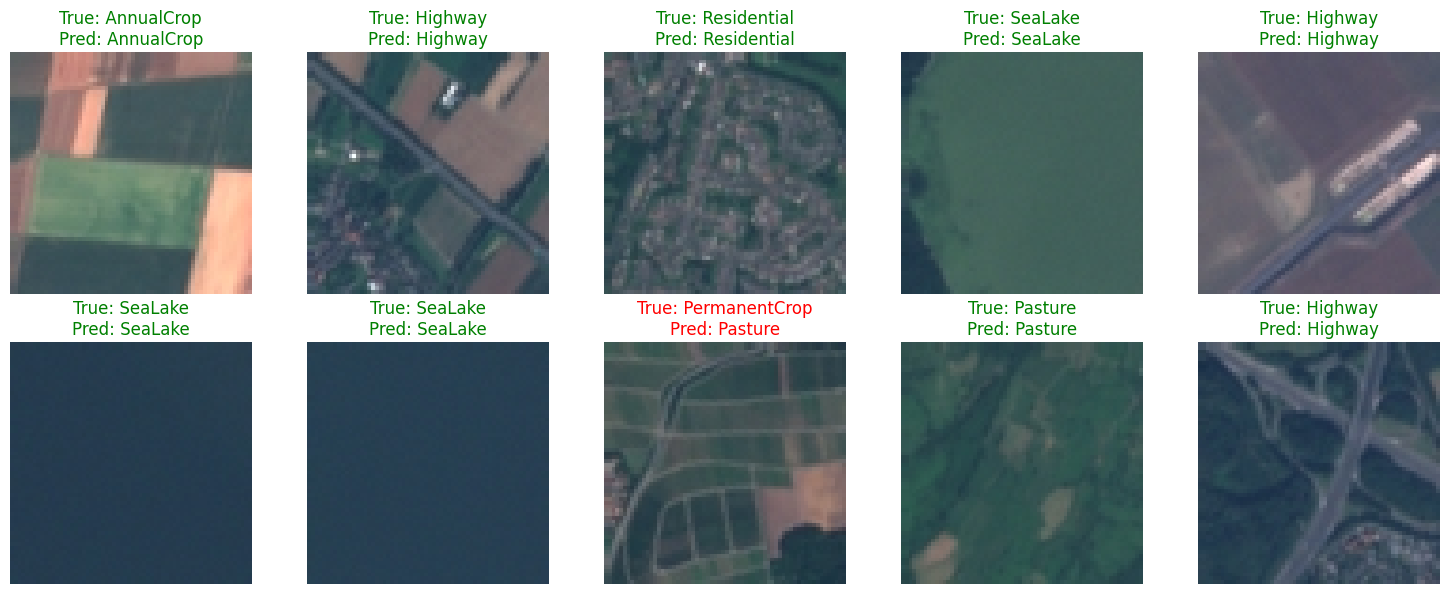

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Error generating class activation maps: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(5, 224, 224, 3)

===== Completed! =====
Check the saved plots in the current directory for visualizations.


Traceback (most recent call last):
  File "<ipython-input-22-31120d266c08>", line 64, in generate_class_activation_maps
    feature_maps = feature_map_model.predict(resized_images)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/input_spec.py", line 245, in assert_input_compatibility
    raise ValueError(
ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(5, 224, 224, 3)


In [ ]:
# Step 3: Create and train the fine-tuned model (unfreeze some layers)
print("\n===== Training Fine-Tuned Model (Some Layers Unfrozen) =====")
fine_tuned_model = create_fine_tuned_model(feature_extractor_model)
fine_tuned_model.summary()
history_fine_tuned = train_model(fine_tuned_model, ds_train, ds_val,
                                   model_name="fine_tuned")

# Step 4: Evaluate the fine-tuned model
labels_ft, preds_ft = evaluate_model(fine_tuned_model, ds_test, class_names,
                                       title="Fine-Tuned Model")

# Step 5: Visualize training history
visualize_training_history(history_feature_extractor, history_fine_tuned)

# Step 6: Visualize sample predictions
visualize_sample_predictions(ds_test, fine_tuned_model, class_names)

# Step 7: Generate class activation maps
generate_class_activation_maps(fine_tuned_model, ds_test, class_names)

print("\n===== Completed! =====")
print("Check the saved plots in the current directory for visualizations.")

Model: Max Pooling


===== Training Fine-Tuned Model (Some Layers Unfrozen) =====


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 14,713,738 (56.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

Epoch 1/20
673/675 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4242 - loss: 1.6872

675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.4245 - loss: 1.6860 - val_accuracy: 0.3333 - val_loss: 2.3938 - learning_rate: 1.0000e-05
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5926 - loss: 1.1325 - val_accuracy: 0.2637 - val_loss: 4.5390 - learning_rate: 1.0000e-05
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6505 - loss: 0.9807 - val_accuracy: 0.3270 - val_loss: 3.0132 - learning_rate: 1.0000e-05
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6872 - loss: 0.8660 - val_accuracy: 0.3007 - val_loss: 4.0730 - learning_rate: 1.0000e-05
Epoch 5/20
673/675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7285 - loss: 0.7679

675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.7285 - loss: 0.7679 - val_accuracy: 0.5630 - val_loss: 1.3341 - learning_rate: 5.0000e-06
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.7565 - loss: 0.6847 - val_accuracy: 0.5137 - val_loss: 1.3029 - learning_rate: 5.0000e-06
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.7601 - loss: 0.6605 - val_accuracy: 0.4122 - val_loss: 4.3626 - learning_rate: 5.0000e-06
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.7759 - loss: 0.6189 - val_accuracy: 0.5189 - val_loss: 1.8713 - learning_rate: 5.0000e-06
Epoch 9/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.7877 - loss: 0.5880 - val_accuracy: 0.2967 - val_loss: 4.9041 - learning_rate: 5.0000e-06
Epoch 10/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8185 - loss: 0.5239

675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.8185 - loss: 0.5239 - val_accuracy: 0.6052 - val_loss: 1.3394 - learning_rate: 2.5000e-06
Epoch 11/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.8295 - loss: 0.4851 - val_accuracy: 0.5178 - val_loss: 1.7262 - learning_rate: 2.5000e-06
Epoch 12/20
673/675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8356 - loss: 0.4735

675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.8356 - loss: 0.4735 - val_accuracy: 0.6337 - val_loss: 1.1876 - learning_rate: 2.5000e-06
Epoch 13/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.8437 - loss: 0.4518 - val_accuracy: 0.6085 - val_loss: 1.4032 - learning_rate: 2.5000e-06
Epoch 14/20
673/675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8514 - loss: 0.4289

675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.8514 - loss: 0.4289 - val_accuracy: 0.6933 - val_loss: 0.9254 - learning_rate: 2.5000e-06
Epoch 15/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8621 - loss: 0.4165 - val_accuracy: 0.5793 - val_loss: 1.7882 - learning_rate: 2.5000e-06
Epoch 16/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8655 - loss: 0.3972 - val_accuracy: 0.5659 - val_loss: 1.3289 - learning_rate: 2.5000e-06
Epoch 17/20
674/675 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8703 - loss: 0.3787

675/675 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8703 - loss: 0.3788 - val_accuracy: 0.6970 - val_loss: 0.8735 - learning_rate: 2.5000e-06
Epoch 18/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.8810 - loss: 0.3675 - val_accuracy: 0.5537 - val_loss: 1.5364 - learning_rate: 2.5000e-06
Epoch 19/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8819 - loss: 0.3540 - val_accuracy: 0.6233 - val_loss: 1.3934 - learning_rate: 2.5000e-06
Epoch 20/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8953 - loss: 0.3292 - val_accuracy: 0.6585 - val_loss: 1.0181 - learning_rate: 2.5000e-06
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6906 - loss: 0.9153

Model Maxpooling:
Test accuracy: 0.6989
Test loss: 0.8769
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━

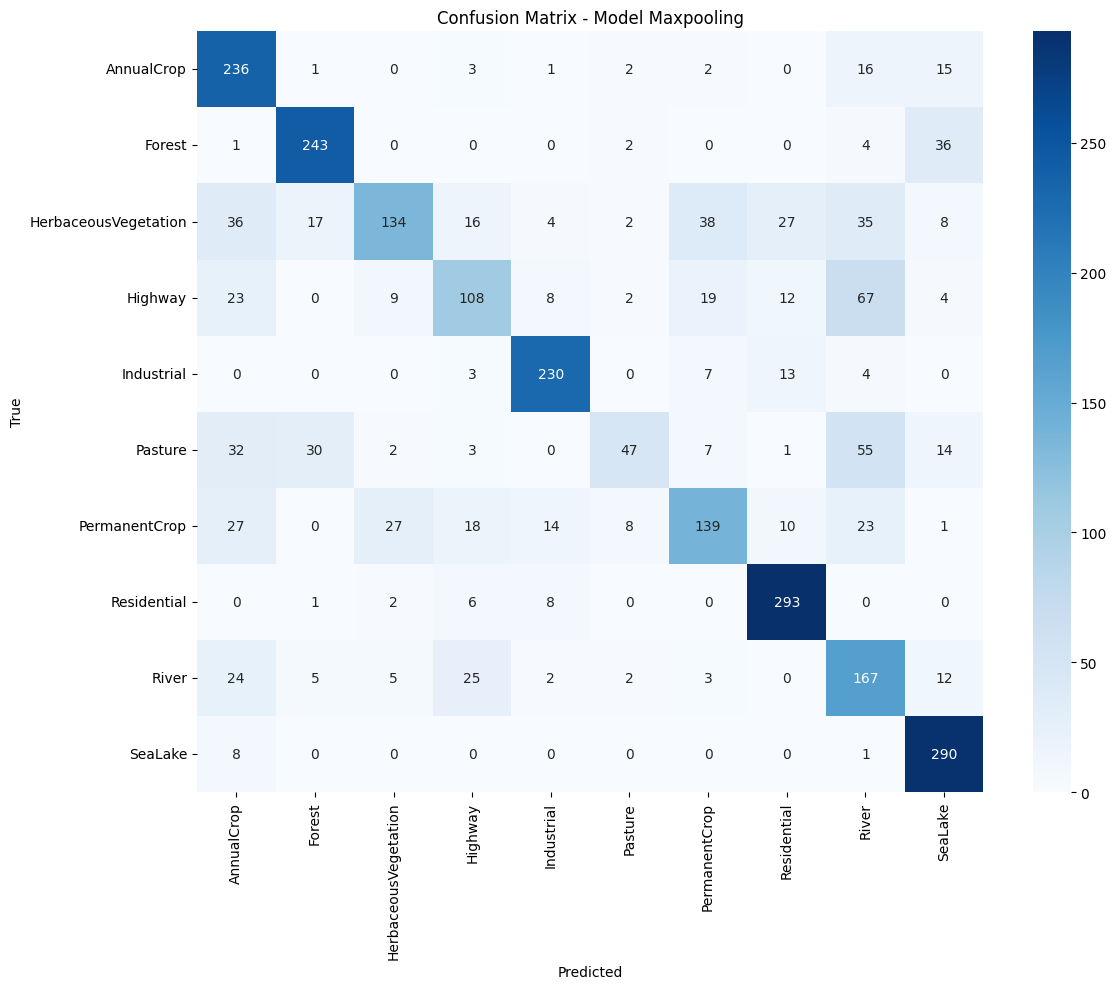


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.61      0.86      0.71       276
              Forest       0.82      0.85      0.83       286
HerbaceousVegetation       0.75      0.42      0.54       317
             Highway       0.59      0.43      0.50       252
          Industrial       0.86      0.89      0.88       257
             Pasture       0.72      0.25      0.37       191
       PermanentCrop       0.65      0.52      0.58       267
         Residential       0.82      0.95      0.88       310
               River       0.45      0.68      0.54       245
             SeaLake       0.76      0.97      0.85       299

            accuracy                           0.70      2700
           macro avg       0.70      0.68      0.67      2700
        weighted avg       0.71      0.70      0.68      2700



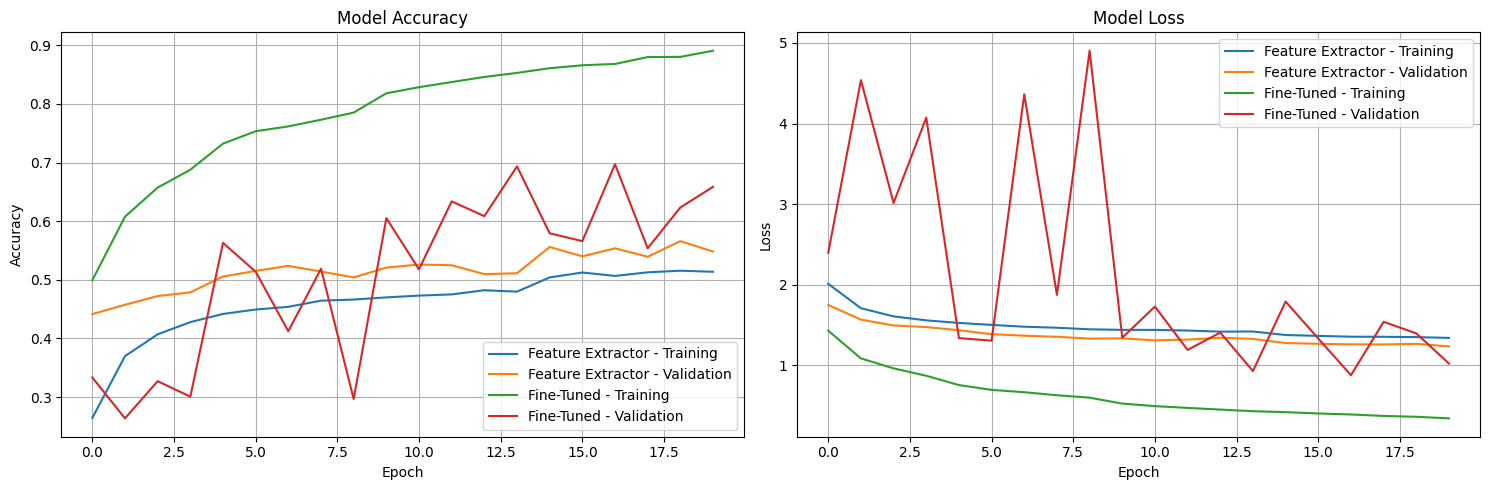

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


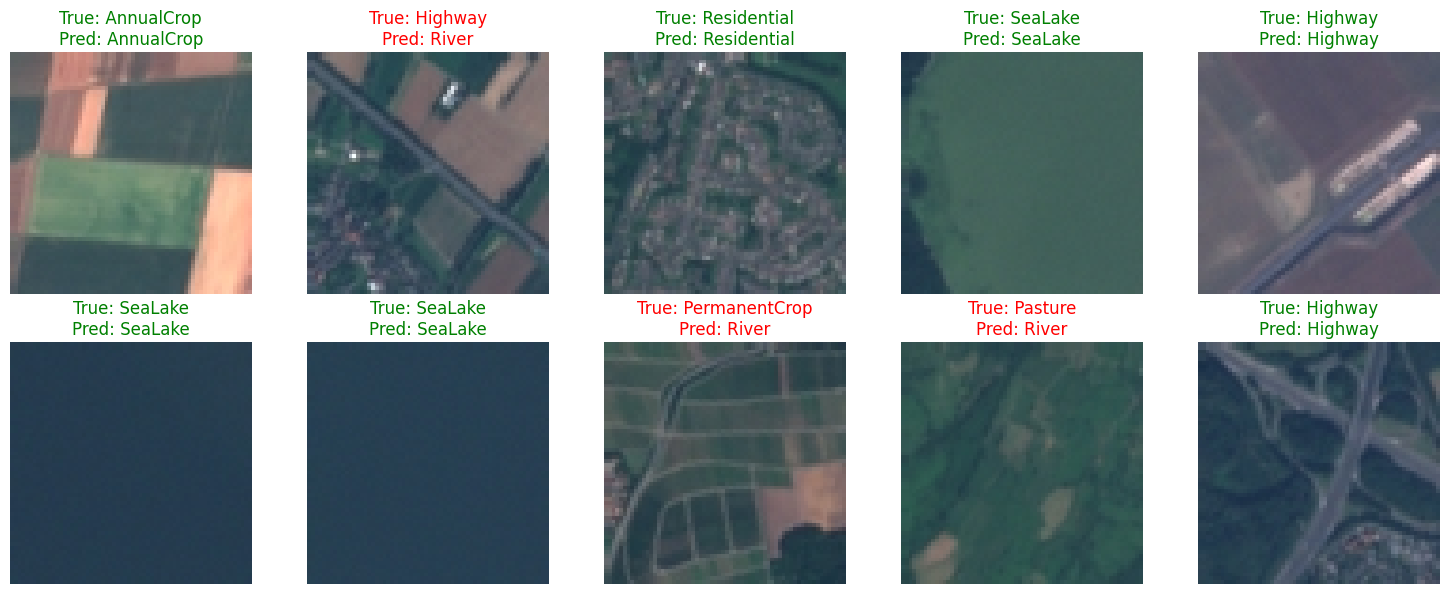

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Error generating class activation maps: Input 0 of layer "functional_4" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(5, 224, 224, 3)

===== Completed! =====
Check the saved plots in the current directory for visualizations.


Traceback (most recent call last):
  File "<ipython-input-22-31120d266c08>", line 64, in generate_class_activation_maps
    feature_maps = feature_map_model.predict(resized_images)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/input_spec.py", line 245, in assert_input_compatibility
    raise ValueError(
ValueError: Input 0 of layer "functional_4" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(5, 224, 224, 3)


In [ ]:
# Step 3: Create and train the fine-tuned model (unfreeze some layers)
print("\n===== Training Fine-Tuned Model (Some Layers Unfrozen) =====")
model_maxpooling = create_fine_tuned_model_maxpooling(feature_extractor_model)
model_maxpooling.summary()
history_maxpooling = train_model(model_maxpooling, ds_train, ds_val,
                                   model_name="model_maxpooling")

# Step 4: Evaluate the fine-tuned model
labels_ft, preds_ft = evaluate_model(model_maxpooling, ds_test, class_names,
                                       title="Model Maxpooling")

# Step 5: Visualize training history
visualize_training_history(history_feature_extractor, history_maxpooling)

# Step 6: Visualize sample predictions
visualize_sample_predictions(ds_test, model_maxpooling, class_names)

# Step 7: Generate class activation maps
generate_class_activation_maps(model_maxpooling, ds_test, class_names)

print("\n===== Completed! =====")
print("Check the saved plots in the current directory for visualizations.")